In [1]:
from sklearn.manifold import TSNE  # Import t-SNE dimensionality reduction algorithm
from sklearn.metrics import accuracy_score  # Import accuracy evaluation metric
from sklearn.decomposition import SparsePCA
from sklearn.neighbors import KNeighborsClassifier  # Import K-nearest neighbors classifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # Set the Chinese font for plotting to SimHei
plt.rcParams['axes.unicode_minus'] = False  # Resolve the issue of displaying negative signs as squares in plots
from PIL import Image
import numpy as np
import os  # Import operating system tools
import pandas as pd

data preprocessing

In [2]:
def image_to_vector(path):
    '''transform 2D image to one dimension array'''
    returnVec = np.zeros(400)
    img = Image.open(path)
    pixel = np.array(img) #2D array
    for i in range(20):
        for j in range(20):
            returnVec[i*20+j] = pixel[i][j] # transform 2d to 1d
    return returnVec

def load_data(dataset_path):
    '''read image data and label'''
    image_list = [] # store image vector
    label_list = [] # store label value

    labels_path_list = os.listdir(dataset_path) # get directory list under datasets path
    labels_path_list.pop(0) # remove the first element

    for i in range(len(labels_path_list)): # list label folders
        image_label_path = dataset_path+'/'+labels_path_list[i] # label folders
        image_path_list = os.listdir(image_label_path) # list images
        for image_path in image_path_list:
            vector = image_to_vector(image_label_path+'/'+image_path)
            image_list.append(vector)
            label_list.append(int(labels_path_list[i]))

    image_list = np.array(image_list)
    label_list = np.array(label_list)
    print('dimension of image vector:',image_list.shape, 'dimension of label:', label_list.shape)
    return image_list, label_list

x_train, y_train = load_data(dataset_path='./data/train')
x_test, y_test = load_data(dataset_path='./data/test')

dimension of image vector: (12706, 400) dimension of label: (12706,)
dimension of image vector: (4669, 400) dimension of label: (4669,)


In [3]:
# standardize data
std = StandardScaler()
x_train_std = std.fit_transform(x_train)
x_test_std = std.fit_transform(x_test)

train k-NN to recognize car license number which have been split.  

In [7]:
# choose optimal parameters
knn_parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
              'weights':['uniform','distance'],
              'p':[1,2] #p=1, Manhattan distance; p=2, the Euclidean distance
              }

knn = KNeighborsClassifier()
# uses cross-validated grid search to find the best combination of hyperparameters.
knn_grid_search = GridSearchCV(knn, knn_parameters, scoring='accuracy', cv=5, verbose=100, n_jobs=1)
knn_grid_search.fit(x_train_std, y_train)
knn_label = knn_grid_search.predict(x_test_std)
print(knn_grid_search.best_score_, knn_grid_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................


[CV 1/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.954 total time=   1.0s
[CV 2/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 2/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.938 total time=   1.0s
[CV 3/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 3/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.948 total time=   1.1s
[CV 4/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 4/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.961 total time=   1.0s
[CV 5/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 5/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.958 total time=   1.0s
[CV 1/5; 2/40] START n_neighbors=1, p=1, weights=distance.......................
[CV 1/5; 2/40] END n_neighbors=1, p=1, weights=distance;, score=0.954 total time=   1.8s
[CV 2/5; 2/40] START n_neighbors=1, p=1, weights=distance.........

In [4]:
# use optimal parameters to train knn
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)
knn.fit(x_train_std, y_train)
knn_predict_label = knn.predict(x_test_std)
knn_acc = accuracy_score(y_test, knn_predict_label)
print(knn_acc)

0.7136431784107946


In [5]:
# report classification results
from sklearn.metrics import classification_report
label = [i for i in range(65)]
knn_report = classification_report(y_test, knn_predict_label, labels=label, output_dict=True)
knn_df = pd.DataFrame(knn_report).transpose()
knn_df.columns = ['knn_precision','knn_recall', 'knn_f1-score', 'knn_support']
print(knn_df)

              knn_precision  knn_recall  knn_f1-score  knn_support
0                  0.316667    0.217143      0.257627   175.000000
1                  0.559524    1.000000      0.717557    94.000000
2                  0.700935    1.000000      0.824176    75.000000
3                  0.615385    0.888889      0.727273    81.000000
4                  0.646288    0.986667      0.781003   150.000000
...                     ...         ...           ...          ...
63                 0.153846    1.000000      0.266667     4.000000
64                 1.000000    0.750000      0.857143     4.000000
accuracy           0.713643    0.713643      0.713643     0.713643
macro avg          0.800276    0.758054      0.737013  4669.000000
weighted avg       0.785628    0.713643      0.705350  4669.000000

[68 rows x 4 columns]


train SVM to recognize car license number

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV #hyperparameter tuning

In [116]:
# choose optimal parameters
svm_parameters = {
    'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
    'gamma': [1e-3, 1e-4, 1e-5],
    'C': [1, 10, 100, 1000]
}

svc = SVC()
svc_grid_search = GridSearchCV(svc, svm_parameters, scoring='accuracy', n_jobs=-1, verbose=2)
svc_grid_search.fit(x_train_std, y_train)
svc_label = svc_grid_search.predict(x_test_std)
print(svc_grid_search.best_score_, svc_grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

In [7]:
svc = SVC(kernel='rbf', gamma=0.0001, C=100)
svc.fit(x_train_std, y_train)
svc_predict_label = svc.predict(x_test_std)
svc_acc = accuracy_score(y_test, svc_predict_label)
print(svc_acc)

0.6761619190404797


In [8]:
# report classification results
from sklearn.metrics import classification_report
label = [i for i in range(65)]
svm_report = classification_report(y_test, svc_predict_label, labels=label, output_dict=True)
svm_df = pd.DataFrame(svm_report).transpose()
svm_df.columns = ['svm_precision','svm_recall', 'svm_f1-score', 'svm_support']
print(svm_df)

              svm_precision  svm_recall  svm_f1-score  svm_support
0                  0.450000    0.360000      0.400000   175.000000
1                  0.580247    1.000000      0.734375    94.000000
2                  0.707547    1.000000      0.828729    75.000000
3                  0.455172    0.814815      0.584071    81.000000
4                  0.552764    0.733333      0.630372   150.000000
...                     ...         ...           ...          ...
63                 0.444444    1.000000      0.615385     4.000000
64                 0.666667    0.500000      0.571429     4.000000
accuracy           0.676162    0.676162      0.676162     0.676162
macro avg          0.659949    0.713505      0.624183  4669.000000
weighted avg       0.775375    0.676162      0.678347  4669.000000

[68 rows x 4 columns]


              knn_precision  knn_recall  knn_f1-score  knn_support  \
0                  0.316667    0.217143      0.257627   175.000000   
1                  0.559524    1.000000      0.717557    94.000000   
2                  0.700935    1.000000      0.824176    75.000000   
3                  0.615385    0.888889      0.727273    81.000000   
4                  0.646288    0.986667      0.781003   150.000000   
...                     ...         ...           ...          ...   
63                 0.153846    1.000000      0.266667     4.000000   
64                 1.000000    0.750000      0.857143     4.000000   
accuracy           0.713643    0.713643      0.713643     0.713643   
macro avg          0.800276    0.758054      0.737013  4669.000000   
weighted avg       0.785628    0.713643      0.705350  4669.000000   

              svm_precision  svm_recall  svm_f1-score  svm_support  
0                  0.450000    0.360000      0.400000   175.000000  
1                  0.

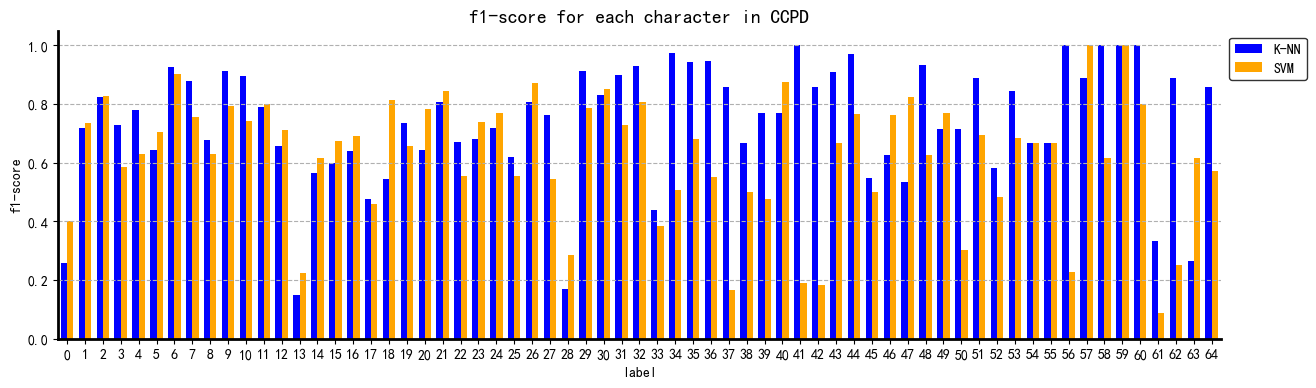

In [10]:
# store report to excel
df = pd.concat([knn_df, svm_df], axis=1)
print(df)
df.to_excel('./CCPD_report.xlsx')

# draw bar chart for KNN and SVM f1-score
fig, ax = plt.subplots(figsize=(15, 4))

bar_width = 0.35
index = knn_df[:-3].index.astype(int)  # Convert index to integers

knn_bars = ax.bar(index - bar_width / 2, knn_df[:-3]['knn_f1-score'], bar_width, label='K-NN', color='blue')
svm_bars = ax.bar(index + bar_width / 2, svm_df[:-3]['svm_f1-score'], bar_width, label='SVM', color='orange')

ax.grid(axis='y', ls='--')
ax.legend(fontsize=10, edgecolor='black', loc='upper right', bbox_to_anchor=(1.08, 1))
ax.set_xlim(-0.5, 64.5)
ax.set_ylim(0, 1.05)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.title('f1-score for each character in CCPD', fontweight='bold', fontsize=14)
plt.xlabel('label')
plt.ylabel('f1-score')

# Adding labels for each bar on the x-axis
ax.set_xticks(index)
ax.set_xticklabels(index)

plt.show()

Normality test for knn and svm accuracy

In [10]:
from scipy import stats
report_data = pd.read_excel('CCPD_report.xlsx')
report_data.head()
KNN_f1 = report_data['knn_f1-score'].to_numpy()
SVM_f1 = report_data['svm_f1-score'].to_numpy()

# Perform the Shapiro-Wilk test on the skewed dataset
knn_statistic, knn_p_value = stats.shapiro(KNN_f1)
svm_statistic, svm_p_value = stats.shapiro(SVM_f1)

# Set the significance level (alpha)
alpha = 0.1

# Interpret the knn results
if knn_p_value > alpha:
    print("knn accuracy looks normally distributed (fail to reject H0)")
else:
    print("knn accuracy does not look normally distributed (reject H0)")

# Print the test statistic and p-value
print(f"Shapiro-Wilk Statistic: {knn_statistic:.4f}")
print(f"P-Value: {knn_p_value:.4f}")

# Interpret the svm results
if svm_p_value > alpha:
    print("svm accuracy looks normally distributed (fail to reject H0)")
else:
    print("svm accuracy does not look normally distributed (reject H0)")

# Print the test statistic and p-value
print(f"Shapiro-Wilk Statistic: {svm_statistic:.4f}")
print(f"P-Value: {svm_p_value:.4f}")

knn accuracy does not look normally distributed (reject H0)
Shapiro-Wilk Statistic: 0.9180
P-Value: 0.0003
svm accuracy does not look normally distributed (reject H0)
Shapiro-Wilk Statistic: 0.9354
P-Value: 0.0016


Wilcoxon Signed-Rank Test for knn and svm

In [11]:
import numpy as np
from scipy import stats


# Perform the Wilcoxon Signed-Rank Test
w_statistic, p_value = stats.wilcoxon(KNN_f1, SVM_f1)

# Print the results
print("Wilcoxon Signed-Rank Statistic:", w_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis - Significant difference between paired samples.")
else:
    print("Fail to reject the null hypothesis - No significant difference between paired samples.")


Wilcoxon Signed-Rank Statistic: 545.0
P-value: 0.0005664738682903446
Reject the null hypothesis - Significant difference between paired samples.


KNN and SVM show significant difference on CCPD. Draw ROC curve to compare their prerformances.

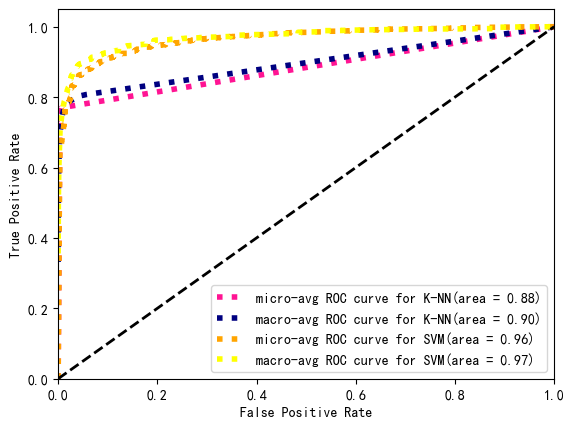

In [12]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

# knn ROC
knn_y_score = knn.predict_proba(x_test_std)

y_test_bin = label_binarize(y_test, classes=list(range(65)))

# compute each character ROC curve and AUC value
knn_fpr = dict()
knn_tpr = dict()
knn_roc_auc = dict()
for i in range(65):
    knn_fpr[i], knn_tpr[i], _ = roc_curve(y_test_bin[:, i], knn_y_score[:, i])
    knn_roc_auc[i] = auc(knn_fpr[i], knn_tpr[i])

# Compute micro-average ROC curve and ROC area
knn_fpr["micro"], knn_tpr["micro"], _ = roc_curve(y_test_bin.ravel(), knn_y_score.ravel())
knn_roc_auc["micro"] = auc(knn_fpr["micro"], knn_tpr["micro"])

# compute marco-average ROC curve and ROC area
all_knn_fpr = np.unique(np.concatenate([knn_fpr[i] for i in range(65)])) # First aggregate all false positive rates
mean_knn_tpr = np.zeros_like(all_knn_fpr) # Then interpolate all ROC curves at this points

for i in range(65):
    mean_knn_tpr += np.interp(all_knn_fpr, knn_fpr[i], knn_tpr[i])


mean_knn_tpr /= 65 # Finally average it and compute AUC
knn_fpr["macro"] = all_knn_fpr
knn_tpr["macro"] = mean_knn_tpr
knn_roc_auc["macro"] = auc(knn_fpr["macro"], knn_tpr["macro"])

# svm ROC
svm_y_score = svc.decision_function(x_test_std)


# compute each character ROC curve and AUC value
svm_fpr = dict()
svm_tpr = dict()
svm_roc_auc = dict()
for i in range(65):
    svm_fpr[i], svm_tpr[i], _ = roc_curve(y_test_bin[:, i], svm_y_score[:, i])
    svm_roc_auc[i] = auc(svm_fpr[i], svm_tpr[i])

# Compute micro-average ROC curve and ROC area
svm_fpr["micro"], svm_tpr["micro"], _ = roc_curve(y_test_bin.ravel(), svm_y_score.ravel())
svm_roc_auc["micro"] = auc(svm_fpr["micro"], svm_tpr["micro"])

# compute marco-average ROC curve and ROC area
all_svm_fpr = np.unique(np.concatenate([svm_fpr[i] for i in range(65)])) # First aggregate all false positive rates
mean_svm_tpr = np.zeros_like(all_svm_fpr) # Then interpolate all ROC curves at this points

for i in range(65):
    mean_svm_tpr += np.interp(all_svm_fpr, svm_fpr[i], svm_tpr[i])


mean_svm_tpr /= 65 # Finally average it and compute AUC
svm_fpr["macro"] = all_svm_fpr
svm_tpr["macro"] = mean_svm_tpr
svm_roc_auc["macro"] = auc(svm_fpr["macro"], svm_tpr["macro"])

# plot all ROC curves
lw=2
plt.figure()
plt.plot(knn_fpr["micro"], knn_tpr["micro"],
         label='micro-avg ROC curve for K-NN(area = {0:0.2f})'
               ''.format(knn_roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(knn_fpr["macro"], knn_tpr["macro"],
         label='macro-avg ROC curve for K-NN(area = {0:0.2f})'
               ''.format(knn_roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(svm_fpr["micro"], svm_tpr["micro"],
         label='micro-avg ROC curve for SVM(area = {0:0.2f})'
               ''.format(svm_roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=4)

plt.plot(svm_fpr["macro"], svm_tpr["macro"],
         label='macro-avg ROC curve for SVM(area = {0:0.2f})'
               ''.format(svm_roc_auc["macro"]),
         color='yellow', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC curve for K-NN and SVM on CCPD datasets')
plt.legend(loc="lower right")
plt.show()